In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import chromatix.functional as cf
import numpy as np
from jax import Array

from sample import R
from tensor_tomo import outer, matvec
from chromatix.utils.utils import sigmoid_taper
from jax.lax import scan
from jax.typing import ArrayLike
from chromatix.utils.fft import fft, ifft
import jax

%config InlineBackend.figure_format='retina'

In [2]:
# Simulation settings
size = (4.55, 11.7, 11.7) # from paper
spacing = 0.065 # [mum], from paper
wavelength = 0.405 # [mum], from paper
n_background = 1.33
n_bead = jnp.array([1.44, 1.40, 1.37])  # z y x
polarisation = cf.linear(0) # x-polarised light
k0 = 2 * jnp.pi / wavelength
bead_radius = 1.5 # [mum]
NA = 0.8

In [36]:
# Getting a sample 
@jax.jit
def paper_sample(bead_orientation: Array) -> Array:
    # Calculating shape
    shape = np.around((np.array(size) / spacing)).astype(int) # without around becomes 1 less!

    # center of pixel is our coordinate
    z = jnp.linspace(1/2*spacing, size[0] - 1/2 * spacing, shape[0])
    y = jnp.linspace(size[1] - 1/2 * spacing, 1/2 * spacing, shape[1])
    x = jnp.linspace(1/2*spacing, size[2] - 1/2 * spacing, shape[2])
    grid = jnp.stack(jnp.meshgrid(z, y, x, indexing="ij"), axis=-1) 

    # Position of each bead, with radius 
    bead_pos = jnp.array([#[size[0] / 2, 8.85, 2.85],
                      #[size[0] / 2, 8.85, 8.85],
                      #[size[0] / 2, 2.85, 2.85],
                      [size[0] / 2, 2.85, 8.85]])
    rotation = jnp.array([#[0.0, jnp.pi/2, 0.0], 
                      #[0, 0.0,0.0],
                      #[0.0, 0.0, jnp.pi/2], 
                      bead_orientation])


    permitivitty = jnp.zeros((*shape, 1, 3, 3))

    # Adding each bead
    for pos, orientation in zip(bead_pos, rotation):
        # Making bead and background
        bead_permitivitty = R(*orientation).T @ jnp.diag(n_bead**2) @ R(*orientation)
        background_permitivitty = jnp.eye(3) * n_background**2

        # Mask
        mask = jnp.sum((grid - pos)**2, axis=-1) < bead_radius ** 2

        # Making sample
        permitivitty += (k0**2 * jnp.where(
            mask[..., None, None, None], background_permitivitty - bead_permitivitty, jnp.zeros((3, 3))
        ))

    return permitivitty

@jax.jit
def thick_polarised_sample(field: cf.VectorField, potential: ArrayLike, n_background: ArrayLike, dz: ArrayLike, NA: float=0.8) -> cf.VectorField:
    def Q_op(u: Array) -> Array:
        # correct
        """Polarisation transfer operator"""
        return crop(ifft(matvec(Q, fft(pad(u)))))
    
    def H_op(u: Array) -> Array:
        # correct
        """Vectorial scattering operator"""
        prefactor = jnp.where(kz > 0, -1j / 2 * jnp.exp(1j * kz * dz) / kz  * dz, 0)
        return crop(ifft(matvec(Q, prefactor * fft(pad(u)))))
    
    def P_op(u: Array) -> Array:
        """Vectorial free space operator"""
        prefactor =  jnp.where(kz > 0, jnp.exp(1j * kz * dz), 0)
        return crop(ifft(matvec(Q, prefactor * fft(pad(u)))))

    def propagate_slice(u: Array, potential_slice: Array) -> tuple[Array, Array]:
        scatter_field = matvec(potential_slice, Q_op(u))
        new_field = P_op(u) + H_op(scatter_field)
        return new_field, new_field

    def pad(u):
        return jnp.pad(u, padding)

    def crop(u):
        return u[:, :field.spatial_shape[0],  :field.spatial_shape[1]]

    # Padding for circular convolution
    padded_shape = 2 * np.array(field.spatial_shape)
    n_pad = padded_shape - np.array(field.spatial_shape)
    padding = ((0, 0), (0, n_pad[0]), (0, n_pad[1]), (0, 0), (0, 0))

    # Getting k_grid 
    k_grid = 2 * jnp.pi * jnp.stack(jnp.meshgrid(jnp.fft.fftfreq(n=padded_shape[0], d=spacing), jnp.fft.fftfreq(n=padded_shape[1], d=spacing), indexing='ij'))[:, None, ..., None, None]
    km = 2 * jnp.pi * n_background / field.spectrum
    kz = jnp.sqrt(jnp.maximum(0.0, km**2 - jnp.sum(k_grid**2, axis=0))) # chop off evanescent waves
    k_grid =  jnp.concatenate([kz[None, ...], k_grid], axis=0)

    # Getting PTFT and band limiting
    Q = (-outer(k_grid / km, k_grid / km, in_axis=0) + jnp.eye(3)).squeeze(-3)
    Q = jnp.where(jnp.sum(k_grid[1:, ..., None]**2, axis=0) <= NA**2 * km**2, Q, 0) # Add the NA here
    
    # Running scan over sample
    u, intermediates = scan(propagate_slice, field.u, potential)
    return field.replace(u=u), intermediates


# Making the field 
field = cf.plane_wave((180, 180), spacing, wavelength, 1.0, amplitude=polarisation, scalar=False)

# Adding a little apodisation
field = field.replace(u = field.u * sigmoid_taper((field.shape[1], field.shape[2]), 4))

In [32]:
# We just run all options and see what matches
options = [-jnp.pi/2, 0, jnp.pi/2]
rotations = []
amplitudes = []
phases = []

for angle_z in options:
    for angle_y in options:
        for angle_x in options:
            rotations.append(jnp.array([angle_z, angle_y, angle_x]))
            potential = paper_sample(rotations[-1])
            out_field, intermediates = thick_polarised_sample(field, potential, n_background, spacing)
            amplitudes.append(out_field.amplitude.squeeze())
            phases.append(out_field.phase.squeeze())

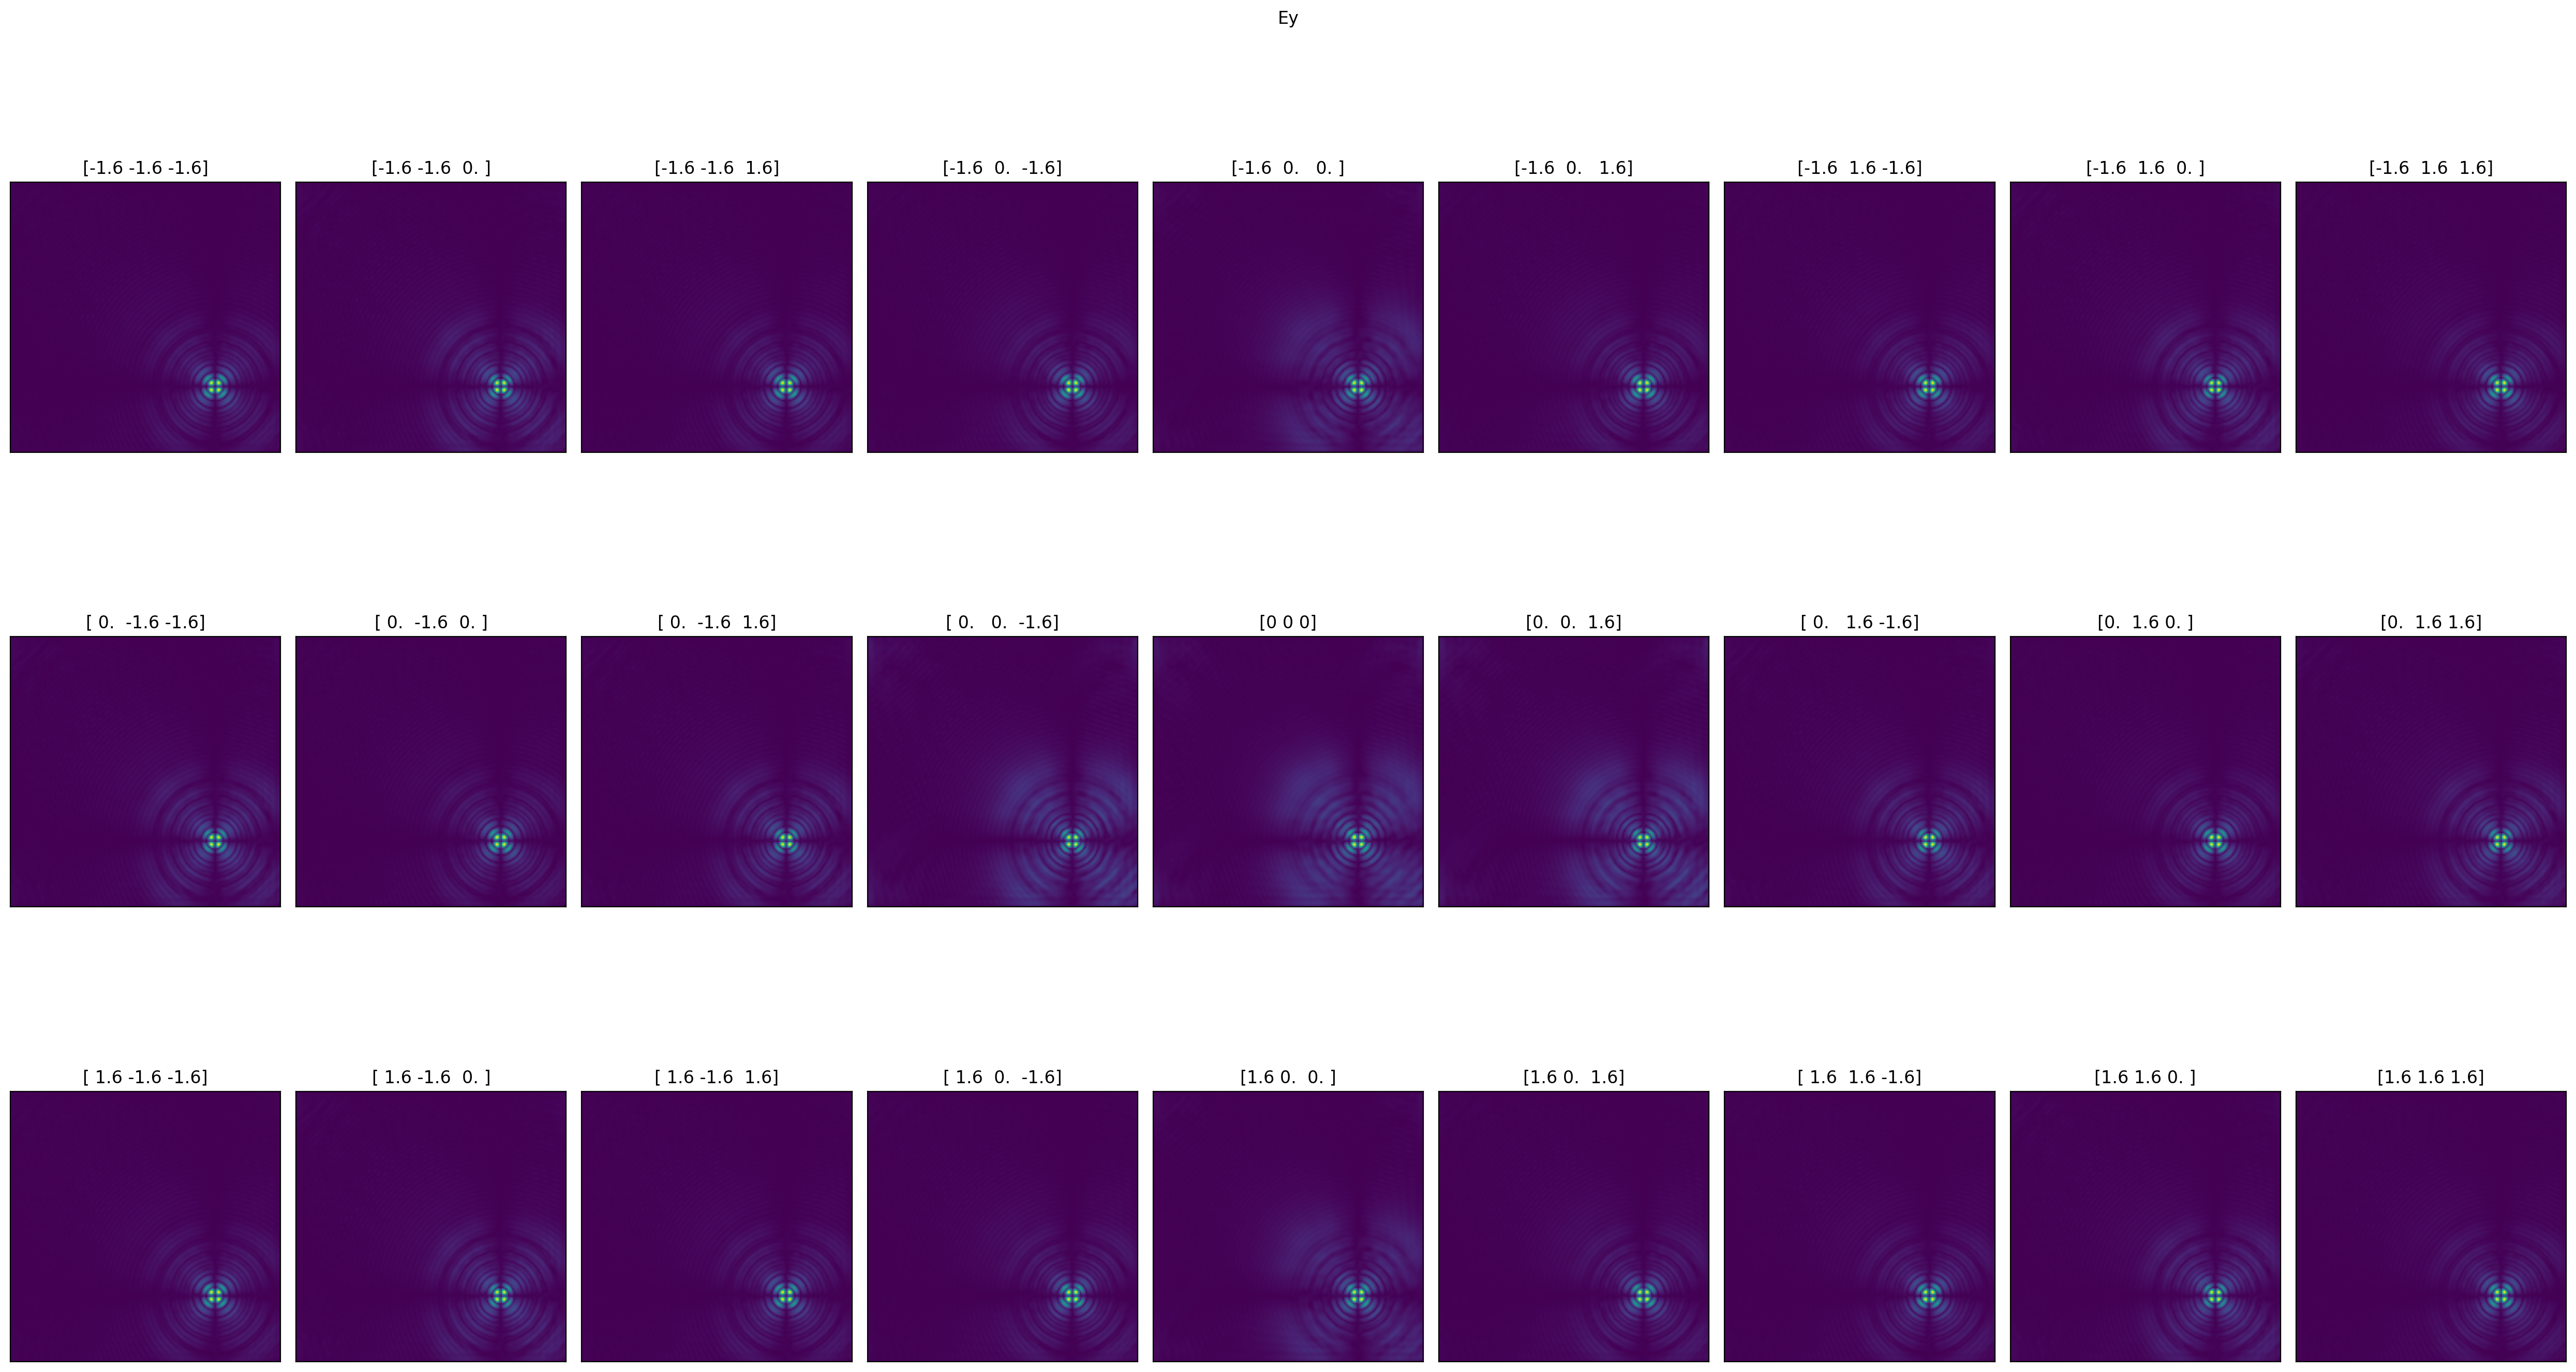

In [33]:
plt.figure(figsize=(25, 15), layout="tight")

idx = 0 
for idx_y in range(1, 4):
    for idx_x in range(1, 10):
        plt.subplot(3, 9, idx + 1)
        plt.imshow(amplitudes[idx][..., 1])
        plt.title(jnp.around(rotations[idx], 1))
        plt.xticks([])
        plt.yticks([])

        idx +=1

plt.suptitle("Ey")
plt.show()

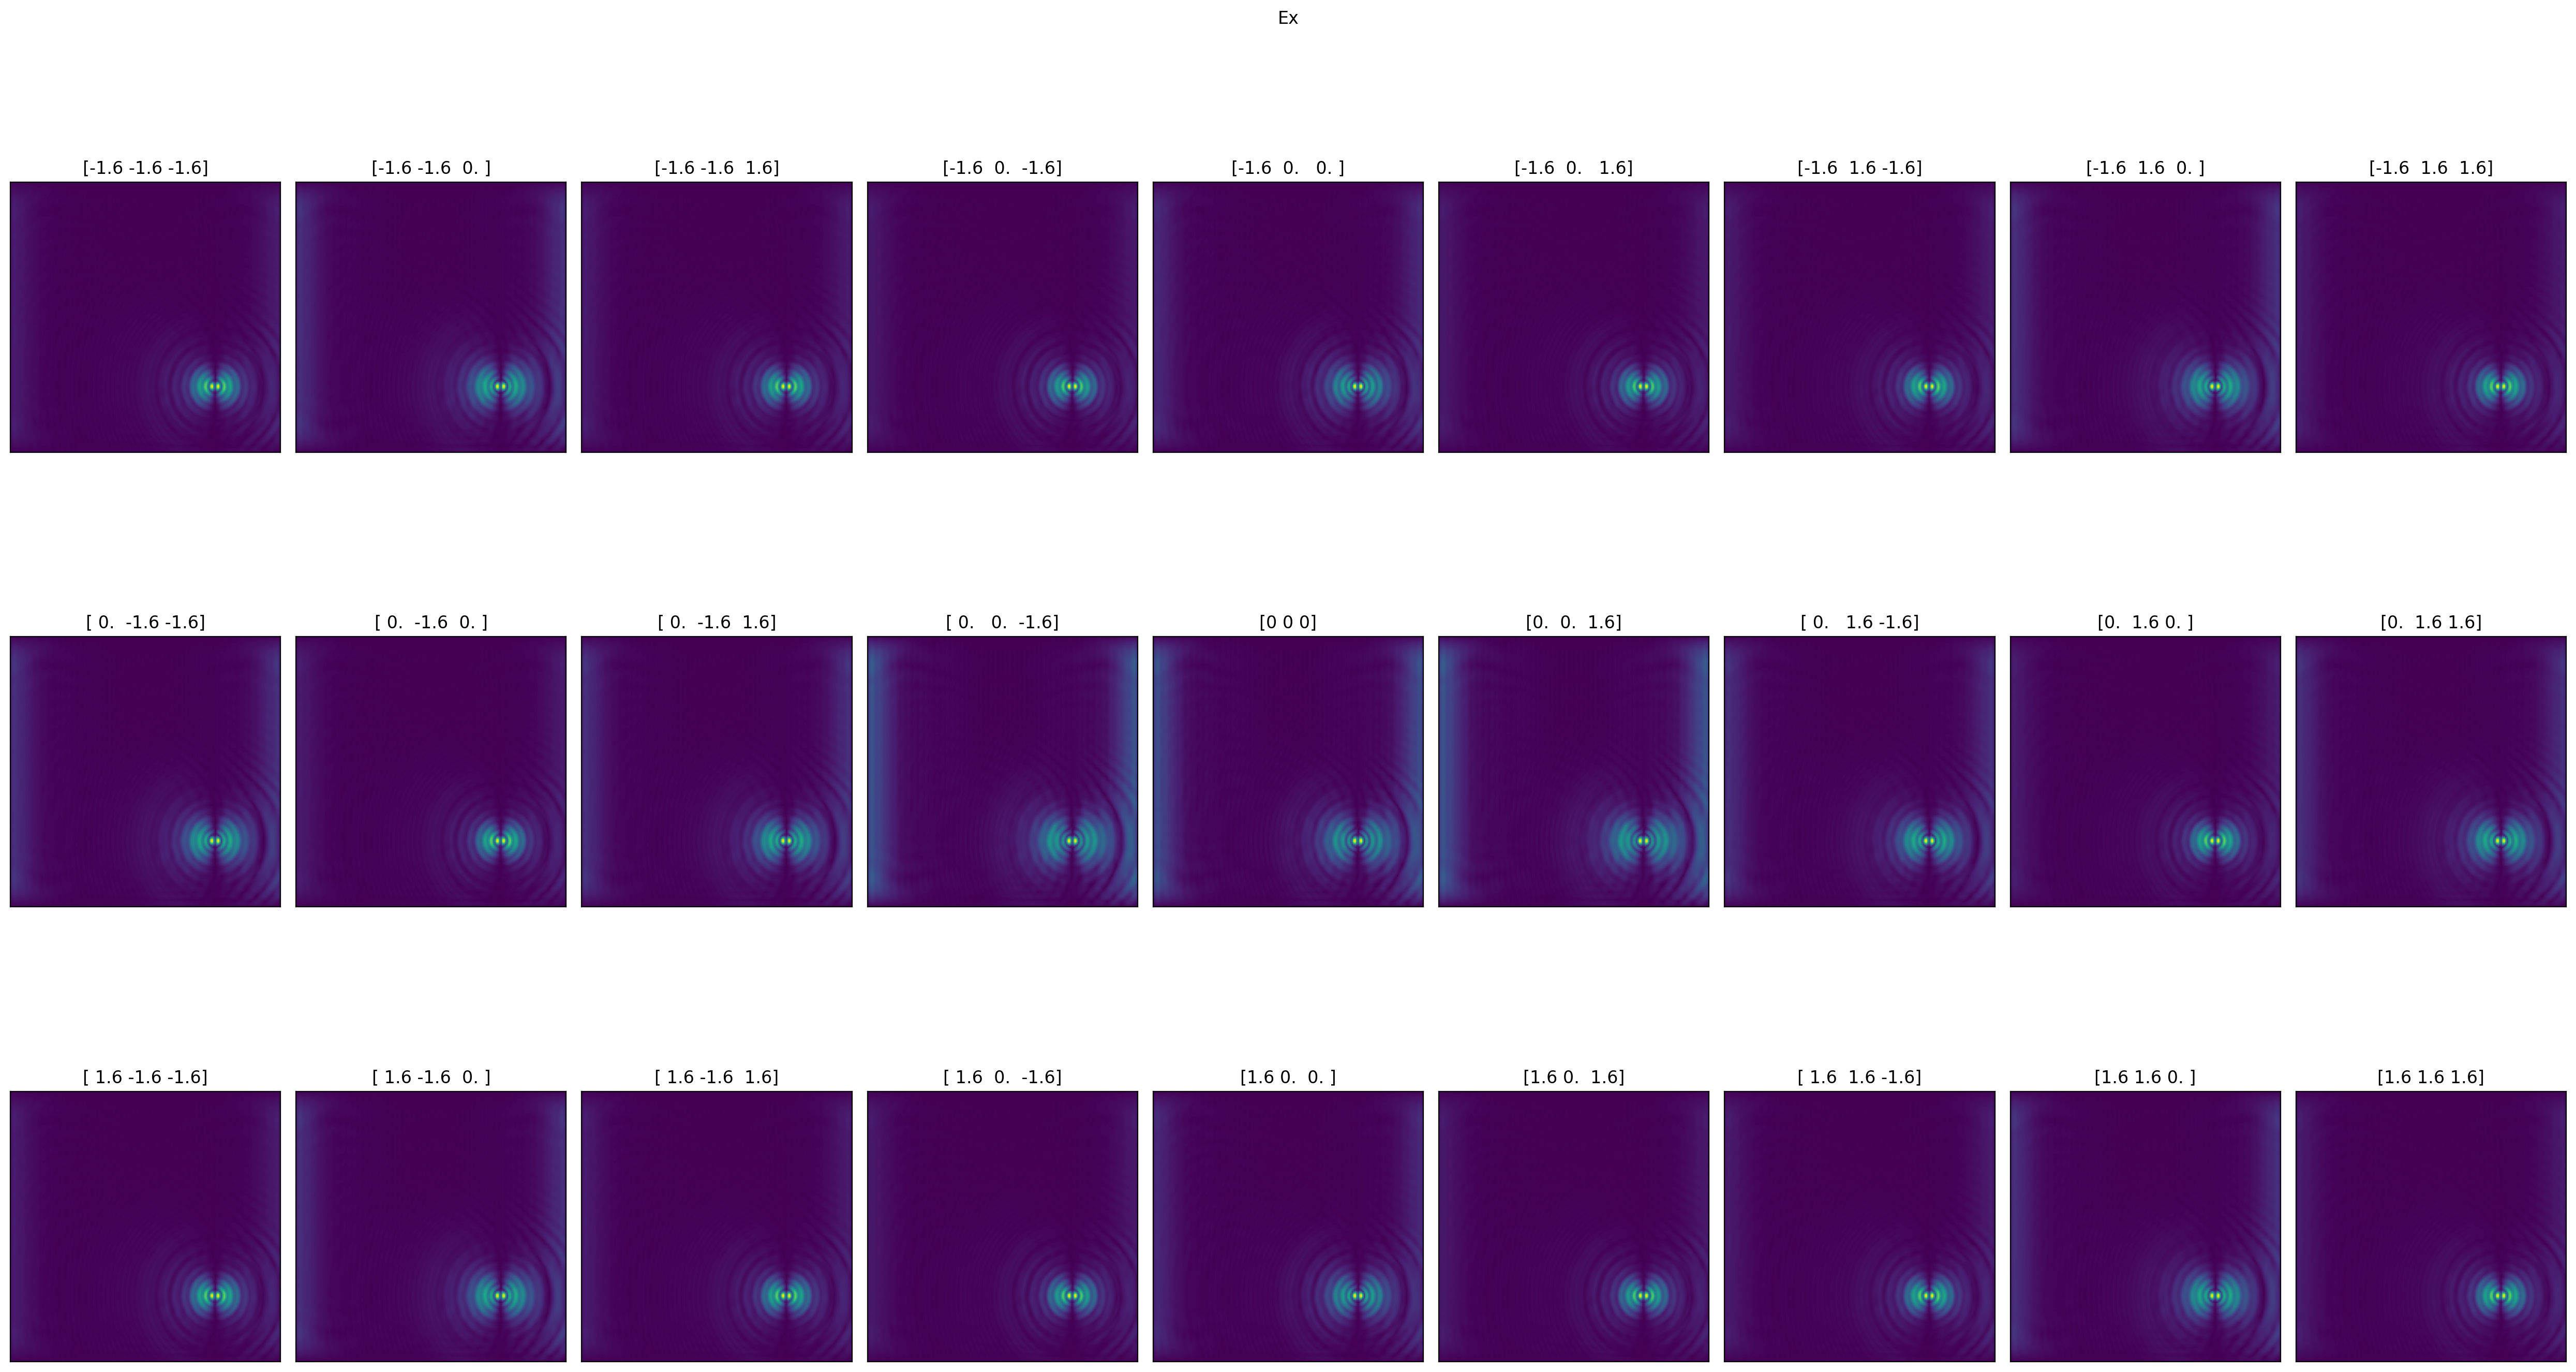

In [34]:
plt.figure(figsize=(25, 15), layout="tight")

idx = 0 
for idx_y in range(1, 4):
    for idx_x in range(1, 10):
        plt.subplot(3, 9, idx + 1)
        plt.imshow(amplitudes[idx][..., 0])
        plt.title(jnp.around(rotations[idx], 1))
        plt.xticks([])
        plt.yticks([])

        idx +=1

plt.suptitle("Ex")
plt.show()

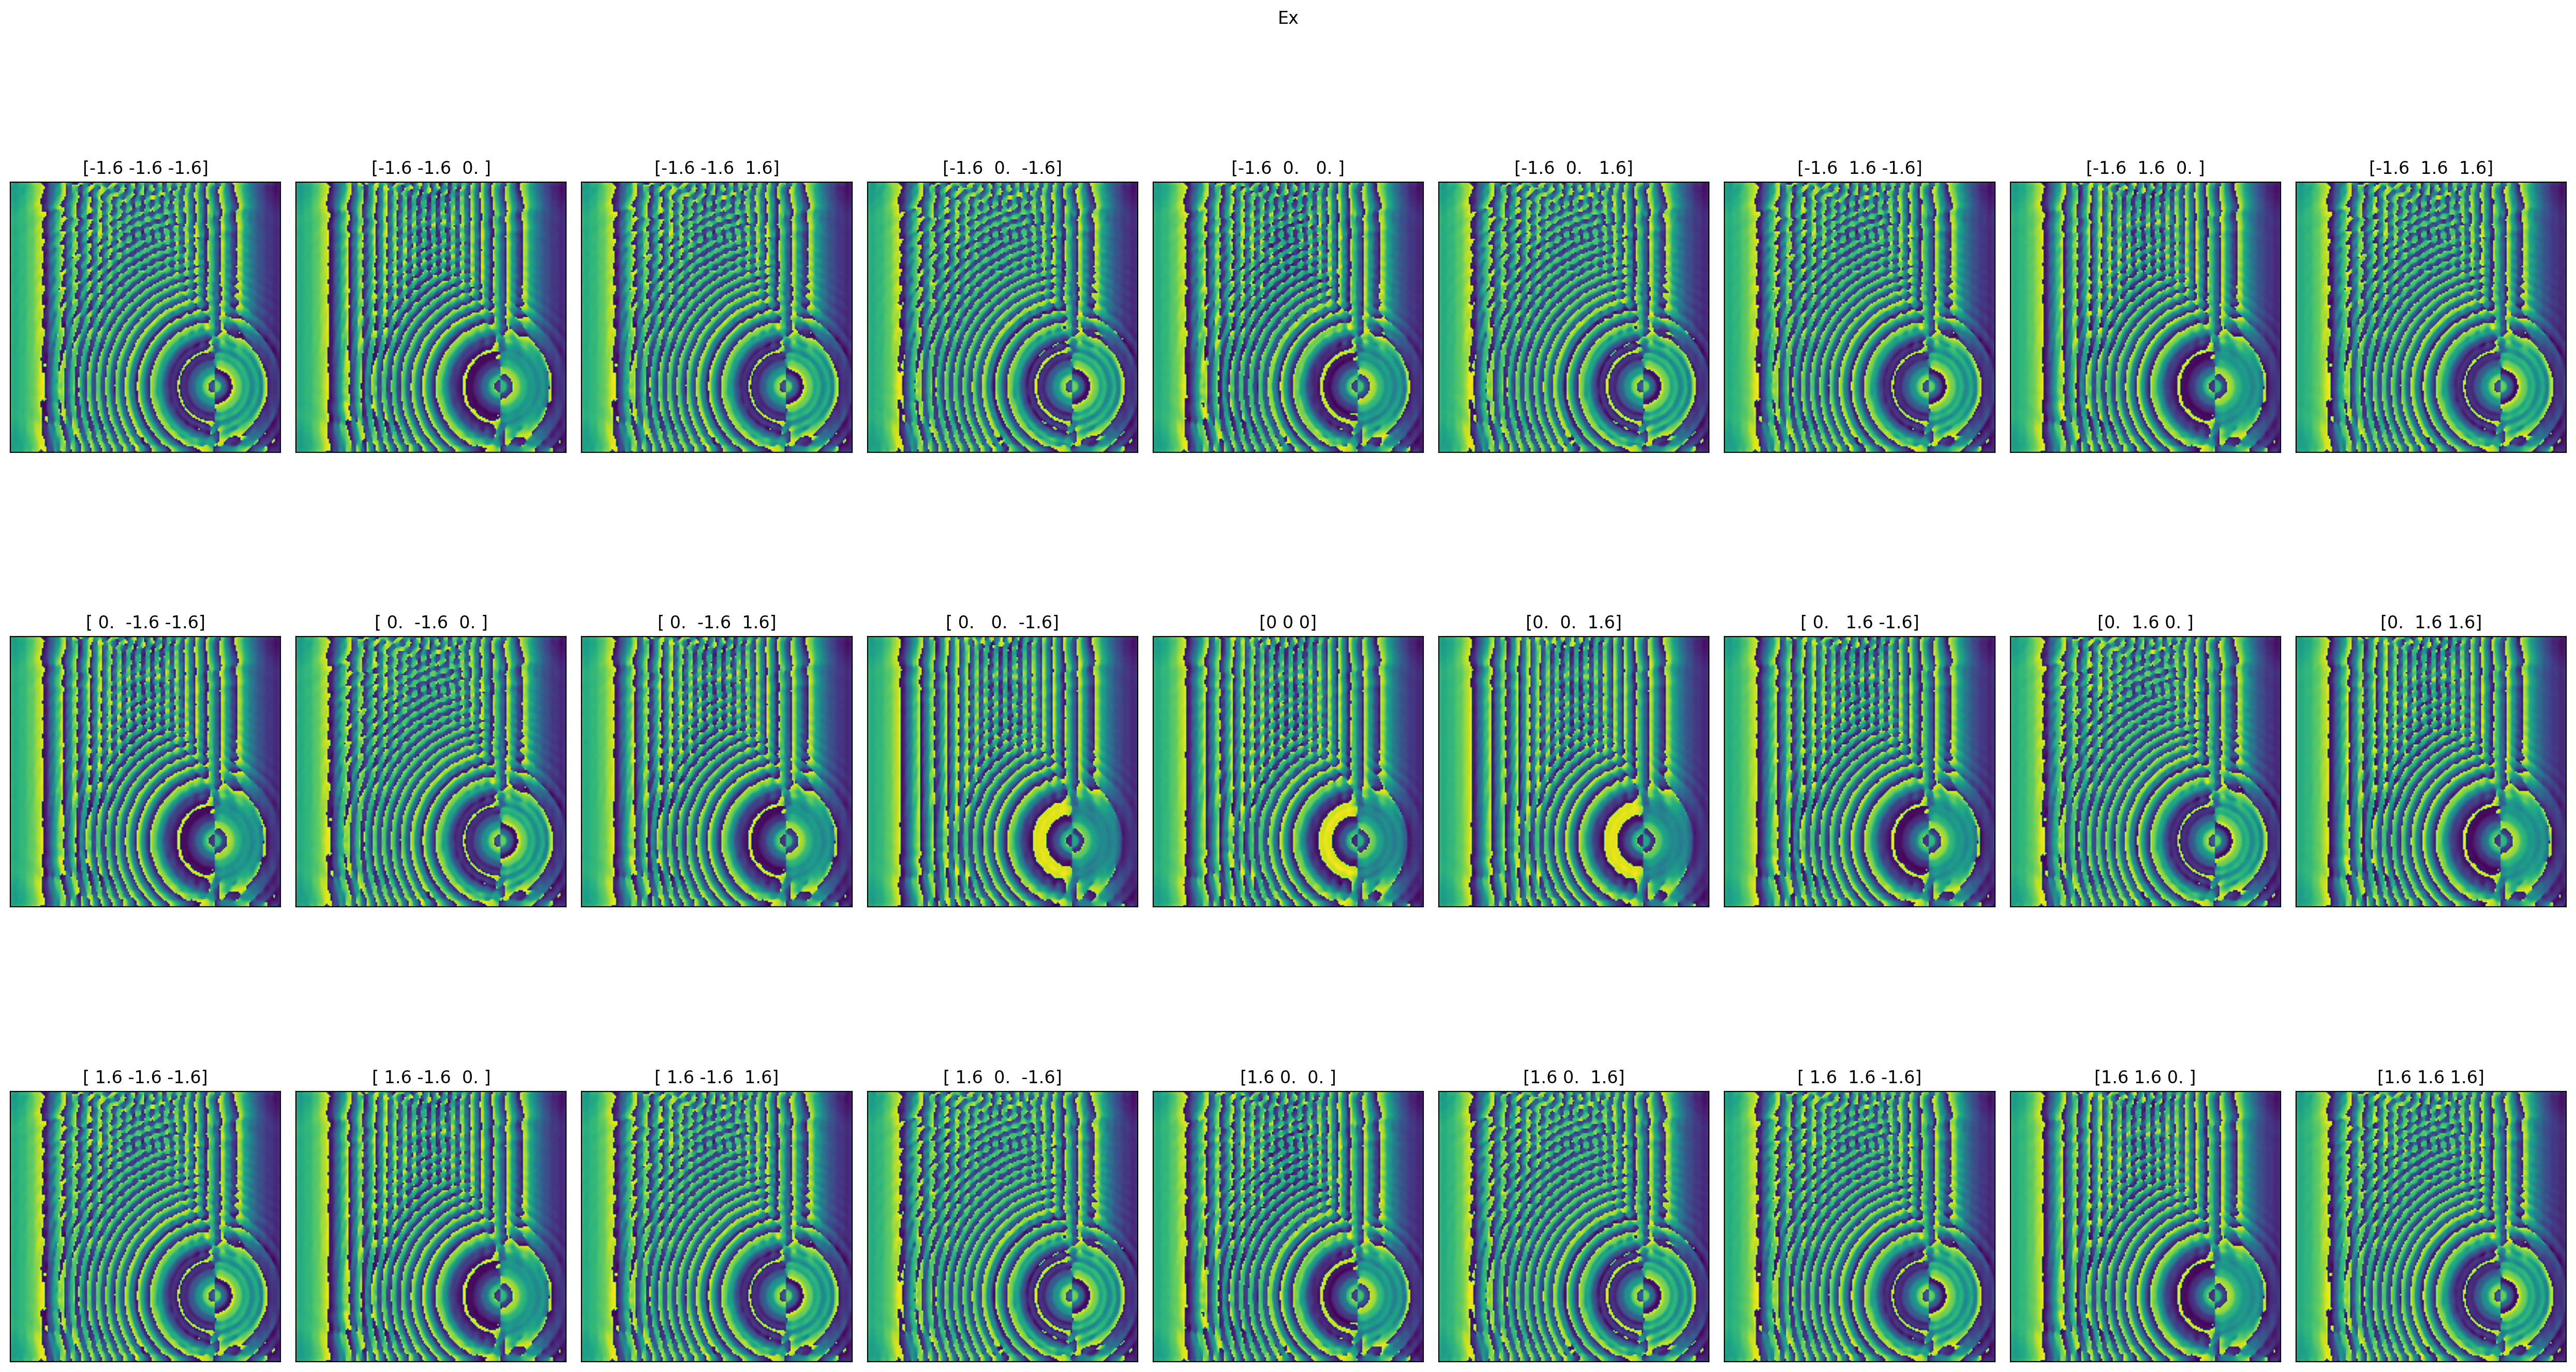

In [35]:
plt.figure(figsize=(25, 15), layout="tight")

idx = 0 
for idx_y in range(1, 4):
    for idx_x in range(1, 10):
        plt.subplot(3, 9, idx + 1)
        plt.imshow(phases[idx][..., 0])
        plt.title(jnp.around(rotations[idx], 1))
        plt.xticks([])
        plt.yticks([])

        idx +=1

plt.suptitle("Ex")
plt.show()

In [20]:
R(*jnp.array([1/4*jnp.pi, 1/4 * jnp.pi, 1/4 * jnp.pi]))

Array([[ 0.49999997,  0.8535534 ,  0.14644668],
       [-0.5       ,  0.14644651,  0.8535534 ],
       [ 0.7071068 , -0.5       ,  0.49999997]], dtype=float32)

In [24]:
r = R(*jnp.array([0, 0, jnp.pi/2]))
r.T @ jnp.diag(jnp.array([1.44, 1.40, 1.37])) @ r

Array([[ 1.4000000e+00, -1.7484592e-09,  0.0000000e+00],
       [-1.7484609e-09,  1.4400001e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  1.3700000e+00]], dtype=float32)

In [29]:
r = R(*jnp.array([jnp.pi/2, 0, 0]))
r.T @ jnp.diag(jnp.array([1.44, 1.40, 1.37])) @ r

Array([[ 1.4400001e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  1.3700000e+00, -1.3113386e-09],
       [ 0.0000000e+00, -1.3113421e-09,  1.4000000e+00]], dtype=float32)

In [30]:
r = R(*jnp.array([0, jnp.pi/2, 0]))
r.T @ jnp.diag(jnp.array([1.44, 1.40, 1.37])) @ r

Array([[1.3700000e+00, 0.0000000e+00, 3.0597995e-09],
       [0.0000000e+00, 1.4000000e+00, 0.0000000e+00],
       [3.0598031e-09, 0.0000000e+00, 1.4400001e+00]], dtype=float32)

In [31]:
r = R(*jnp.array([0, jnp.pi/2, jnp.pi/2]))
r.T @ jnp.diag(jnp.array([1.44, 1.40, 1.37])) @ r

Array([[1.3700000e+00, 7.6427737e-17, 1.3113386e-09],
       [7.6427737e-17, 1.4400001e+00, 1.7484609e-09],
       [1.3113421e-09, 1.7484592e-09, 1.4000000e+00]], dtype=float32)